# 다른 토크나이저 사용해보기

1. 문제 파악
2. 데이터 탐색  
    - 데이터 시각화
3. 데이터 전처리 
    - 텍스트 데이터 전처리
    - 임베딩
4. 학습
    - 여러 모델 성능 비교
    - 모델 적용
        - test data 임베딩
        - 결과 예측
6. 모델 개선
    - 모델 확정
    - 파라미터 튜닝 (그리드 서치)
    - 결과 예측

# 1. 문제 파악

* Hashcode 사이트의 질문글
:개발자들을 위한 무료 QnA 사이트로 한글인 질문과 전공용어인 영어, 코드의 내용들이 섞여 있는 코퍼스
   : 이러한 특성 때문에 타 말뭉치와 다른 점이 있다면,  
     
    (1) 프로그래밍 전공 용어가 들어간다.   
        : 딥러닝을 사용할 경우 wiki 백과에 각 언어의 설명이나 각종 documentation으로 코퍼스를 수집, pre-trained 된 모델을 가져와 임베딩을 fine-tunning 시킬 수 있다. 하지만 해당 문제는 데이터 개수가 적은 편이어서 외부 코퍼스가 문제 코퍼스보다 커질 우려가 있다.  
        : 분류를 각 (프로그래밍) 언어 별로 하게 되어 있다.
            => 언어에 따라, 타 언어와 유사한 토큰이 등장할 수 있다.
            ==> 따라서 tf-idf 방식으로 임베딩을 진행한다.
    (2) 사용자가 생성하는 것은 정규화된 언어(뉴스 등)가 아니다.
        : 오타나 이모티콘(ㅠㅠ, ㅋㅋ, 등)이 있다.
        : 전공용어는 영어로 질문은 한글로 적는 등, 두 개의 언어가 혼합되어 있다.
    (3) 답을 알려줄만한 노골적인 키워드는 특수문자로 제거되었다. (ex: 파이썬 질문 있어요 -> $$$ 질문 있어요)

필요한 모듈 임포드

In [2]:
# 데이터 처리에 필요한 모듈 임포트
import MeCab
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# 기계학습에 필요한 모듈 임포드
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV

# 멀티 라벨 분류 모델 임포트
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

In [61]:
m = MeCab.Tagger("-O wakati")
text = r"안녕하십니까... 혼자서 해결해보려고 하다가 도저히 모르겠어서 질문 올립니다."
aa = m.parse(text)
aa.split(' ')

['안녕',
 '하',
 '십니까',
 '.',
 '..',
 '혼자',
 '서',
 '해결',
 '해',
 '보',
 '려고',
 '하',
 '다가',
 '도저히',
 '모르',
 '겠',
 '어서',
 '질문',
 '올립니다',
 '.',
 '\n']

In [55]:
from konlpy.tag import Twitter 
twitter = Twitter()
twitter.morphs('시험시험')

c:\python\venv\nlp\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')
c:\python\venv\nlp\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


['시험', '시험']

데이터 다운로드

In [11]:
path = 'C:\Python\Ground\data\hashcode\hashcode_classification2020_{}.csv'
load = lambda x: pd.read_csv(path.format(x))

In [12]:
sample = load('sample')
test = load('test')
train = load('train')

In [13]:
label_dict = {1:'C',2:'C++',3:'java',4:'javascript', 5:'python'}
label_names = list(label_dict.values())

In [14]:
def pre(text):
    # 공백 제거, ㅠㅠ ㅋㅋ 등의 감정 표현 이모티콘 제거, 숫자 제거, 이미지 제거
    # 괄호나 :, ; 등의 문자는 각 언어의 특징점이 될 수 있어 그대로 놔둠
    stop1 = re.compile(r'[\t\r\n\v\f,]+')
    stop2 = re.compile(r'[?!#`ㄱ-ㅎㅏ-ㅣ]+|[0-9]+.?[0-9]*|  |(\.|\*|~|;|\| ){2,}|(_|-|=|/|\||\+){4,}')
    stop3 = re.compile(r'\[이미지\]\[?|\[\:|http[a-zA-Z\.:/\-\=]+[(png)|(jpg)|(jpeg)]')

    text = re.sub(stop1, ' ', text)
    text = re.sub(stop2,'', text)
    text = re.sub(stop3,'', text)
    return text

# 주어진 코퍼스를 각 라벨 별로 분류하여, 전체를 한 문서로 보고 데이터 탐색
def make_doc(label_num):
    # 5개 라벨을 기준으로 5개의 문서 만들기
    total = train[train.label==label_num].title+' '+train[train.label==label_num].content
    text = ''
    for i in total:
        text +=' '+str(i)
    text = pre(text)
    return text

def top_k(label,k):
    doc = make_doc(label)
    vect = CountVectorizer().fit([doc])
    count = vect.transform([doc]).toarray().sum(axis=0)
    idx = np.argsort(-count)
    count = count[idx]
    feature_name = np.array(vect.get_feature_names())[idx]
    print(list(zip(feature_name, count))[:k])

In [15]:
k=30
for label in label_dict:
    print('='*100)
    print('코퍼스의 {} 언어에서 TOP {}개 최빈 토큰:'.format(label_dict[label], k))
    top_k(label, k)
    print()

코퍼스의 C 언어에서 TOP 30개 최빈 토큰:
[('int', 866), ('printf', 551), ('if', 356), ('void', 303), ('for', 277), ('char', 259), ('return', 204), ('include', 188), ('null', 159), ('num', 147), ('else', 146), ('str', 141), ('head', 139), ('bit', 136), ('main', 132), ('temp', 128), ('data', 117), ('porta_reg', 110), ('_delay_us', 107), ('while', 107), ('node', 104), ('sizeof', 94), ('stdio', 91), ('arr', 89), ('break', 89), ('struct', 87), ('어떻게', 84), ('scanf', 80), ('us', 72), ('cycle_us', 71)]

코퍼스의 C++ 언어에서 TOP 30개 최빈 토큰:
[('int', 722), ('cout', 384), ('endl', 271), ('if', 259), ('std', 250), ('void', 247), ('return', 217), ('string', 184), ('include', 182), ('for', 156), ('const', 156), ('char', 154), ('class', 137), ('this', 136), ('name', 119), ('public', 116), ('main', 108), ('new', 99), ('어떻게', 98), ('else', 93), ('input', 89), ('case', 85), ('using', 83), ('value', 80), ('size', 75), ('printf', 74), ('node', 72), ('end', 72), ('break', 71), ('iostream', 70)]

코퍼스의 java 언어에서 TOP 30개 최빈 토큰:
[

위의 결과로 각 문서 간 유사도가 높게 나타날 것이라고 예상할 수 있다.

In [16]:
doc1, doc2, doc3, doc4, doc5 = make_doc(1), make_doc(2), make_doc(3), make_doc(4), make_doc(5)

In [17]:
# 문서 토큰화를 미리 진행해보고, '질문글'의 특성 상 나타날 수 밖에 없는 토큰들을 stop_words로 추가한다.
stoplist = ['은','는','이','가','을','를','안','못','의','에서','에는','에서는',
            '로','으로','만','그','같이','다','라는','게','라고',
            '왜','이런','저런','문제','질문',
            '와','과','또는','도',
            '죠',
            '되다','되어다',
            '경우',
            '이렇게', '이렇다', '오다', '가다','늘다',
            '아래','다음',
            '코드','변수','발생','에러','오류','뜨다',
            '해보다','해주다',
            '이다','있다','않다','없다','아니다','싶다','하다','어떻다','모르다',
            '궁금하다','도움','필요하다','부탁드리다','안녕하다','감사하다',
            '예','들다'
            ]

In [23]:
tfidf_corpus = [doc1, doc2, doc3, doc4, doc5]
tfidf_vectorizer = TfidfVectorizer(
    # 너무 희소한 데이터는 그 질문에서만 쓰이는 데이터나 변수명이 될 수 있어 제거
    min_df = 0.05, 
    # 괄호나 기호 등이 코드에서 자주 쓰이고, 이것이 언어의 특징점이 될 수 있어 n-gram 설정
    ngram_range=(1,5),
    # 소문자/대문자를 구별하는 언어가 있기 때문에 소문자화는 진행하지 않는다.
    lowercase=False,
    # '질문글'이라면 흔히 나타날만한 토큰들 (ex. '모르다', '궁금하다')을 stopwords로 추가한다.
#     stop_words=stoplist,
    # 코퍼스가 많지 않기 때문에 희소벡터의 수를 줄이기 위해 stemming 실행
    tokenizer=lambda x:m.parse(x))

tfidf = tfidf_vectorizer.fit_transform(tfidf_corpus)
tfidf.shape

(5, 658791)

밀집벡터로 임베딩 후 각 문서 간 유사도 확인

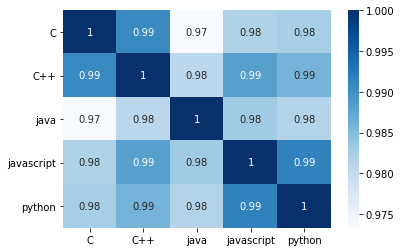

In [24]:
sim = tfidf*tfidf.T
label_names = list(label_dict.values())
sim_df = pd.DataFrame(sim.todense(), columns = label_names, index = label_names)
sns.heatmap(sim_df, annot = True, cmap='Blues')
plt.show()

### 3-(2) 임베딩

In [25]:
title = pd.Series(map(lambda x: pre(str(x)), train.title))
content = pd.Series(map(lambda x: pre(str(x)), train.content))
data = title+content

In [27]:
# 각 문서 간 (언어 간) 유사도가 상당히 높은 편이다. 따라서 tfidf로 임베딩 할 때 max_df 인자를 추가시킨다.
fixed_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    min_df=3,
    max_df=0.8,
    ngram_range=(1,5),
    lowercase=False,
#     stop_words=stoplist,
    tokenizer=lambda x:m.parse(x))

fixed_tfidf = fixed_vectorizer.fit_transform(data)
fixed_tfidf.shape

c:\python\venv\nlp\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['\n', ' ', '감', '같', '경', '고', '궁', '금', '녕', '늘', '니', '되', '드', '들', '떻', '또', '뜨', '라', '래', '러', '런', '렇', '류', '르', '리', '모', '문', '발', '변', '보', '부', '사', '생', '서', '수', '싶', '아', '않', '어', '없', '에', '오', '요', '우', '움', '으', '음', '있', '저', '제', '주', '질', '코', '탁', '필', '하', '해'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(2592, 148885)

In [28]:
features = fixed_tfidf.toarray()
labels = train.label

In [29]:
features.shape, labels.shape

((2592, 148885), (2592,))

# 4. 학습

### 4-(1) 여러 모델 성능 비교

In [31]:
x_train, x_test, y_train, y_test = train_test_split(
      data, train.label, stratify=train.label, # data는 텍스트 전처리가 끝나있는 상태
      random_state=0, test_size=0.25)

In [32]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

# 빠른 테스트를 위해 세부적인 파라미터는 일단 무시
_pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf',SVC())
])
_pipe.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,

In [33]:
pipe_train_score = _pipe.score(x_train, y_train)
pipe_test_score = _pipe.score(x_test, y_test)

In [34]:
pipe_train_score, pipe_test_score

(0.9984567901234568, 0.7222222222222222)

In [35]:
parameters = {'clf__kernel':['linear','rbf','poly']}

In [36]:
grid = GridSearchCV(_pipe, parameters, cv=5, n_jobs=-1)

In [37]:
grid.fit(x_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [38]:
print('optimal parameter is {}'.format(grid.best_params_))
print('best CV score is {:.3f}'.format(grid.best_score_))
print('best test score is {:.3f}'.format(grid.score(x_test, y_test)))

optimal parameter is {'clf__kernel': 'linear'}
best CV score is 0.747
best test score is 0.799


In [40]:
def get_score(pipe):
    pipe.fit(x_train, y_train)
    pipe_train_score = pipe.score(x_train, y_train)
    pipe_test_score = pipe.score(x_test, y_test)
    print('train score is {:.4f}'.format(pipe_train_score))
    print('test score is {:.4f}'.format(pipe_test_score))

In [41]:
pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf',SVC(kernel='linear'))
])
get_score(pipe)

train score is 0.9943
test score is 0.7994


In [42]:
pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf',LinearSVC())
])
get_score(pipe)

train score is 1.0000
test score is 0.8025


위의 결과를 통해 linearSVC()를 사용해도 무방하다는 사실을 확인할 수 있다.  
(엄밀히 따지면 SVC(kernel='linear)와 LinearSVC()는 그 결과값이 약간은 다르지만,  
LinearSVC()가 조금 더 빠르고 값이 잘 나온다.)

모델을 LinearSVC()로 확정하고, 다음 파라미터 튜닝을 진행한다.

### 5-(2) 그리드서치

In [66]:
T = lambda x:m.parse(x).split(' ')

In [67]:
pipe = Pipeline([
    ('vect', CountVectorizer(tokenizer=T)),
    ('tfidf', TfidfTransformer()),
    ('clf',LinearSVC())
])
get_score(pipe)

train score is 0.9990
test score is 0.8086


토크나이저를 사용하면 score가 올라가긴 하지만 연산이 너무 오래 걸린다. 토크나이저를 따로 추가하는 것은 다른 파라미터 튜닝 후, 마지막 단계에서 수행한다.

In [68]:
TfidfVectorizer().get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [69]:
CountVectorizer().get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

In [48]:
TfidfTransformer().get_params()

{'norm': 'l2', 'smooth_idf': True, 'sublinear_tf': False, 'use_idf': True}

In [49]:
LinearSVC().get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

토크나이저를 적용시키고 그리드서치를 할 경우 에러가 발생... 수동으로 찾아준다.

In [75]:
pipe = Pipeline([
    ('vect', CountVectorizer(
        min_df=1, max_df=0.3,
        ngram_range=(1,2),
        lowercase=False,
#         stop_words=stoplist,
        tokenizer=T
    )),
    ('tfidf', TfidfTransformer(
        smooth_idf=False,
        sublinear_tf=True)),
    ('clf',LinearSVC(C=5, random_state=0))
])
get_score(pipe)

train score is 1.0000
test score is 0.8503


In [79]:
pipe = Pipeline([
    ('vect', CountVectorizer(
        min_df=1, max_df=0.3,
        ngram_range=(1,3),
        lowercase=False,
#         stop_words=stoplist,
        tokenizer=T
    )),
    ('tfidf', TfidfTransformer(
        smooth_idf=False,
        sublinear_tf=True)),
    ('clf',LinearSVC(C=5, random_state=0))
])
get_score(pipe)

train score is 1.0000
test score is 0.8441


In [80]:
pipe = Pipeline([
    ('vect', CountVectorizer(
        min_df=1, max_df=0.3,
        ngram_range=(1,5),
        lowercase=False,
#         stop_words=stoplist,
        tokenizer=T
    )),
    ('tfidf', TfidfTransformer(
        smooth_idf=False,
        sublinear_tf=True)),
    ('clf',LinearSVC(C=5, random_state=0))
])
get_score(pipe)

train score is 1.0000
test score is 0.8349


### 5-(3) 최종 모델 선택 후 결과 예측

In [83]:
# 문서 토큰화를 미리 진행해보고, '질문글'의 특성 상 나타날 수 밖에 없는 토큰들을 stop_words로 추가한다.
stoplist = ['은','는','이','가','을','를','안','못','의','에서','에는','에서는',
            '로','으로','만','그','같이','다','라는','게','라고',
            '왜','이런','저런','문제','질문',
            '와','과','또는','도',
            '죠',
            '되다','되어다',
            '경우',
            '이렇게', '이렇다', '오다', '가다','늘다',
            '아래','다음',
            '코드','변수','발생','에러','오류','뜨다',
            '해보다','해주다',
            '이다','있다','않다','없다','아니다','싶다','하다','어떻다','모르다',
            '궁금하다','도움','필요하다','부탁드리다','안녕하다','감사하다',
            '예','들다',
            '\n', '감사', '궁금', '늘', '되', '드리', '들', '뜨', '모르', '보다', '부탁', '싶', 
            '아니', '안녕', '않', '어다', '어떻', '없', '에', '이렇', '있', '주', '필요', '하', '해',
            '보', '어'
            ]

In [84]:
pipe = Pipeline([
    ('vect', CountVectorizer(
        min_df=1, max_df=0.3,
        ngram_range=(1,2),
        lowercase=False,
        stop_words=stoplist,
        tokenizer=T
    )),
    ('tfidf', TfidfTransformer(
        smooth_idf=False,
        sublinear_tf=True)),
    ('clf',LinearSVC(C=5))
])
get_score(pipe)

pipe.fit(x_train, y_train)

train score is 1.0000
test score is 0.8503


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=False, max_df=0.3,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=['은', '는', '이', '가', '을', '를', '안',
                                             '못', '의', '에서', '에는', '에서는', '로',
                                             '으로', '만', '그', '같이', '다', '라는',
                                             '게...
                                 tokenizer=<function <lambda> at 0x00000217279CF1F8>,
                                 vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=False,
                         

In [85]:
title = pd.Series(map(lambda x: pre(str(x)), test.title))
content = pd.Series(map(lambda x: pre(str(x)), test.content))
X_test = title+content

In [86]:
y_hat=pipe.predict(X_test)

In [87]:
y_hat

array([5, 4, 1, 3, 5, 3, 5, 4, 4, 3, 2, 5, 5, 5, 2, 3, 4, 1, 1, 2, 3, 5,
       3, 5, 3, 5, 5, 2, 5, 3, 4, 3, 5, 4, 3, 5, 1, 4, 4, 5, 1, 4, 2, 3,
       4, 1, 3, 2, 4, 3, 4, 3, 1, 1, 1, 2, 5, 5, 3, 5, 3, 2, 5, 3, 2, 5,
       3, 4, 3, 3, 3, 5, 3, 4, 4, 4, 3, 5, 2, 3, 5, 1, 3, 4, 4, 4, 4, 5,
       2, 3, 3, 1, 3, 3, 1, 1, 1, 5, 2, 4, 3, 3, 5, 1, 1, 1, 4, 4, 1, 4,
       2, 2, 1, 3, 3, 5, 4, 4, 4, 1, 2, 2, 4, 1, 4, 3, 5, 1, 3, 5, 2, 2,
       2, 3, 4, 3, 5, 4, 3, 3, 5, 5, 5, 5, 3, 2, 3, 4, 3, 5, 4, 3, 1, 3,
       3, 5, 2, 4, 5, 4, 3, 2, 5, 4, 1, 3, 3, 4, 3, 3, 1, 3, 5, 5, 3, 5,
       4, 1, 4, 4, 1, 5, 3, 5, 2, 4, 5, 1, 3, 3, 1, 4, 5, 3, 2, 4, 3, 4,
       1, 4, 1, 3, 3, 5, 3, 2, 2, 4, 3, 4, 1, 1, 2, 5, 1, 5, 1, 5, 3, 4,
       5, 3, 4, 1, 3, 1, 5, 5, 3, 3, 5, 3, 4, 1, 2, 4, 5, 1, 5, 2, 4, 2,
       5, 2, 1, 4, 4, 1, 1, 3, 2, 3, 1, 2, 5, 2, 3, 3, 3, 2, 5, 5, 3, 1,
       5, 1, 3, 4, 3, 3, 1, 5, 3, 3, 4, 1, 2, 4, 1, 1, 2, 5, 1, 1, 5, 1,
       1, 3, 5, 3, 1, 2, 5, 1, 4, 4, 1, 3, 5, 3, 1,

In [68]:
# y_result

array([5, 4, 1, 3, 5, 3, 5, 4, 3, 3, 2, 5, 5, 5, 5, 3, 4, 1, 1, 2, 3, 5,
       3, 5, 3, 5, 5, 2, 5, 3, 4, 3, 5, 4, 3, 5, 1, 4, 4, 5, 1, 4, 2, 3,
       4, 1, 3, 2, 4, 3, 4, 3, 1, 1, 1, 2, 5, 5, 3, 5, 3, 2, 5, 3, 2, 5,
       3, 4, 3, 2, 3, 5, 3, 4, 4, 4, 3, 5, 2, 3, 1, 1, 3, 4, 4, 4, 4, 5,
       2, 3, 3, 1, 3, 3, 1, 1, 1, 5, 2, 4, 3, 3, 5, 1, 1, 1, 4, 4, 1, 4,
       2, 2, 4, 3, 3, 5, 4, 5, 2, 1, 2, 2, 4, 1, 4, 3, 5, 1, 2, 5, 2, 2,
       2, 3, 4, 3, 5, 3, 3, 3, 5, 5, 5, 5, 3, 2, 3, 4, 3, 5, 4, 3, 1, 3,
       3, 5, 2, 4, 3, 4, 3, 2, 5, 4, 1, 3, 3, 4, 3, 3, 1, 3, 5, 5, 3, 5,
       4, 1, 4, 4, 3, 5, 3, 5, 2, 3, 5, 1, 3, 3, 1, 4, 5, 3, 2, 4, 4, 4,
       1, 4, 1, 3, 3, 5, 3, 2, 2, 4, 3, 4, 1, 1, 2, 3, 1, 5, 1, 5, 3, 4,
       5, 3, 4, 1, 3, 1, 5, 5, 3, 3, 5, 3, 4, 1, 2, 4, 5, 1, 5, 2, 4, 2,
       5, 2, 1, 4, 4, 1, 1, 3, 2, 3, 1, 2, 5, 2, 4, 3, 3, 1, 5, 3, 4, 1,
       5, 1, 3, 4, 3, 3, 1, 5, 3, 3, 4, 1, 2, 4, 1, 1, 2, 5, 1, 1, 5, 1,
       1, 3, 5, 3, 1, 2, 5, 1, 4, 4, 1, 3, 5, 3, 1,

In [69]:
# pd.DataFrame({'label':y_result}).to_csv('tfidf_pred_2.0.csv',index=False)
# pd.read_csv('tfidf_pred_2.0.csv')

,label
0,5
1,4
2,1
3,3
4,5
...,...
495,3
496,1
497,1
498,3
